# Algorithmic Fairness, Accountability, and Ethics, Spring 2025

## Mandatory Assignment 1

Please use the following code to prepare the dataet.
 

In [168]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from fairlearn.postprocessing import ThresholdOptimizer
import matplotlib.pyplot as plt
import shap

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=False)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 "DIS", # Disability classification
                 "VPS", # Veteran status
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    dis = df["DIS"].values-1
    # Veteran data binary
    df["VPS"]=-(df["VPS"].notnull().astype(int)-1)
    df["VPS"]=df["VPS"].fillna(0)
    vps = df["VPS"].values
    # SCHL data grouping 
    # grouping 16+17 and 22+23
    df['SCHL'].replace({17.0:16.0, 18.0:17.0, 19.0:18.0, 20.0:19.0, 21.0:20.0, 22.0:21.0, 23.0:21.0, 24.0:22.0}, inplace=True)
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "MAR", "SEX", "RAC1P", "DIS", "VPS"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    # For one-hot encoding ENG, which we decided not to do
    #df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    
    df_processed["SEX_2"]=df_processed["SEX_2"].astype(bool)
    df_processed["DIS_2"]=df_processed["DIS_2"].astype(bool)
    df_processed["VPS_1"]=df_processed["VPS_1"].astype(bool)
    return df_processed, df, target, sex, dis, vps

data, data_original, target, group_sex, group_dis, group_vps = data_processing(acs_data, feature_names, target_name)


C:\Users\Bruger\AppData\Local\Temp\ipykernel_18776\396926254.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['SCHL'].replace({17.0:16.0, 18.0:17.0, 19.0:18.0, 20.0:19.0, 21.0:20.0, 22.0:21.0, 23.0:21.0, 24.0:22.0}, inplace=True)


# Task 1 - Classifiers and fairness considerations
## Feature engineering and scaling
### Standardizing the school, age and english ability data

Firstly we want to convert the age data to range between 0 and 1, since all other given features are categorical and one-hot-encoded. Furthermore we look how the categorical data is distributed, which is mainly to get a feel from the data. 

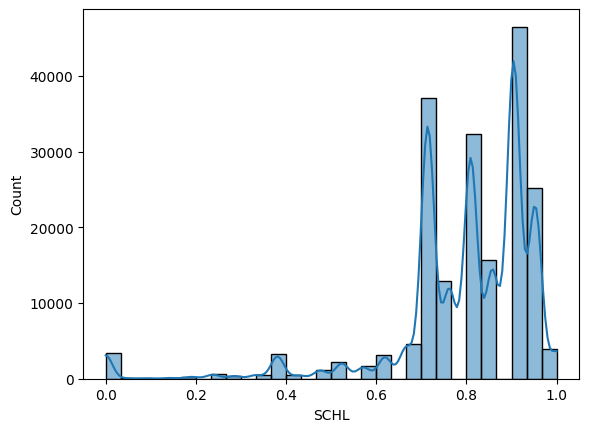

In [169]:
# Standardized age dataet
scaler=MinMaxScaler()
data["SCHL"]=scaler.fit_transform(data[["SCHL"]])

sns.histplot(data["SCHL"], bins=30, kde=True)  
plt.show()

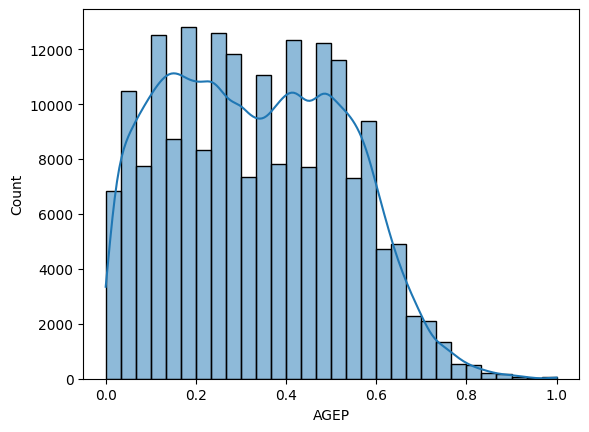

In [170]:
# Standardized age dataet
scaler=MinMaxScaler()
data["AGEP"]=scaler.fit_transform(data[["AGEP"]]).astype(float)

sns.histplot(data["AGEP"], bins=30, kde=True)  
plt.show()

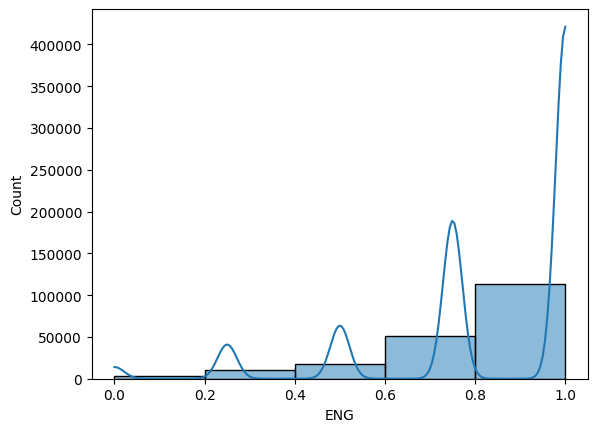

In [171]:
# Filling nan values with zero
data["ENG"]=data["ENG"].fillna(0)

# Flipping the data such that 0 is no english ability and 4 is native/professional
data["ENG"]=-(data["ENG"]-4)

scaler=MinMaxScaler()
data["ENG"]=scaler.fit_transform(data[["ENG"]]).astype(float)

sns.histplot(data["ENG"], bins=5, kde=True)  
plt.show()

## Getting a feeling of the categorical data
### Disability, sex and veteran status

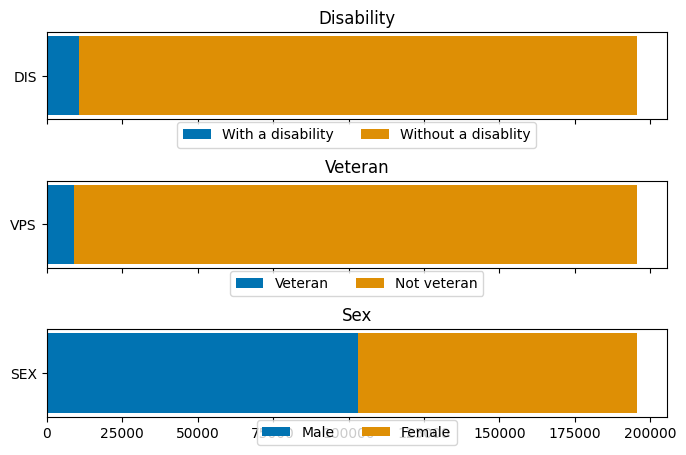

In [172]:
# Create the horizontal stacked bar
fig, ax = plt.subplots(nrows=3, figsize=(8, 5), sharex=True)

# Disability
labels=["With a disability", "Without a disablity"]
values = [sum(data[f"DIS_2"])]
values = [len(data)-sum(values)]+values
colors =sns.color_palette('colorblind', 2)

fig.subplots_adjust(hspace=0.7)
ax[0].barh(["DIS"], values[0], color=colors[0], label=labels[0])
ax[0].barh(["DIS"], values[1], left=values[0], color=colors[1], label=labels[1])


ax[0].set_title("Disability")
ax[0].legend(loc='lower center',bbox_to_anchor=(0.5, -0.4),ncol=2)

# Veteran
labels=["Veteran", "Not veteran"]
values = [sum(data["VPS_1"])]
values = [len(data)-sum(values)]+values
colors =sns.color_palette('colorblind', 2)

ax[1].barh(["VPS"], values[0], color=colors[0], label=labels[0])
ax[1].barh(["VPS"], values[1], left=values[0], color=colors[1], label=labels[1])

ax[1].set_title("Veteran")
ax[1].legend(loc='lower center',bbox_to_anchor=(0.5, -0.4),ncol=2)

# Sex
labels=["Male", "Female"]
values = [sum(data["SEX_2"])]
values = [len(data)-sum(values)]+values
colors =sns.color_palette('colorblind', 2)

ax[2].barh(["SEX"], values[0], color=colors[0], label=labels[0])
ax[2].barh(["SEX"], values[1], left=values[0], color=colors[1], label=labels[1])

ax[2].set_title("Sex")
ax[2].legend(loc='lower center',bbox_to_anchor=(0.5, -0.4),ncol=2)

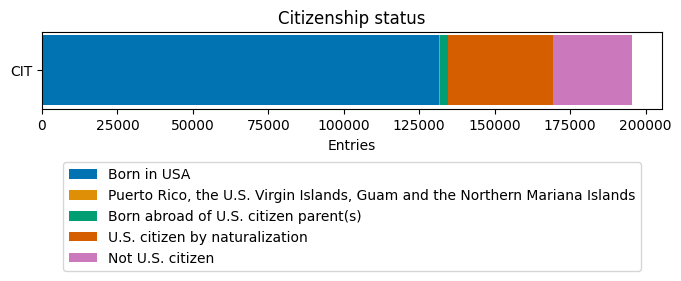

In [173]:
# Sample data for one stacked bar
labels = ["Born in USA", "Puerto Rico, the U.S. Virgin Islands, Guam and the Northern Mariana Islands", "Born abroad of U.S. citizen parent(s)", "U.S. citizen by naturalization", "Not U.S. citizen"]
values = [sum(data[f"CIT_{i}"]) for i in range(2, 6)]
values = [len(data)-sum(values)]+values
Ncat=len(values)
colors =sns.color_palette('colorblind', Ncat)

# Create the horizontal stacked bar
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh(["CIT"], values[0], color=colors[0], label=labels[0])

for i in range(1,Ncat):
    ax.barh(["CIT"], values[i], left=sum(values[0:i]), color=colors[i], label=labels[i])
 
# Labels and legend
ax.set_xlabel("Entries")
ax.set_title("Citizenship status")
ax.legend(loc='lower center',bbox_to_anchor=(0.5, -2.2))

# Show plot
plt.show()

### Working class

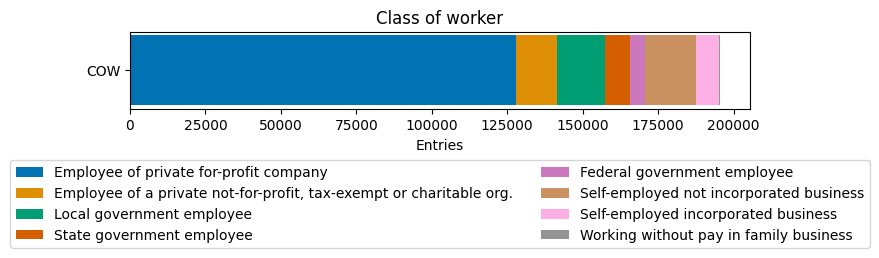

In [174]:
# Sample data for one stacked bar
labels = ["Employee of private for-profit company", "Employee of a private not-for-profit, tax-exempt or charitable org.", "Local government employee", "State government employee", "Federal government employee", "Self-employed not incorporated business", "Self-employed incorporated business", "Working without pay in family business"]#, "Unemployed at least 5 years"]
values = [sum(data[f"COW_{i}.0"]) for i in range(2, 9)]
values = [len(data)-sum(values)]+values
# Number of categories
Ncat=len(values)

# Choosing color for stacked bar
colors =sns.color_palette('colorblind', Ncat)

# Create the horizontal stacked bar
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh(["COW"], values[0], color=colors[0], label=labels[0])

for i in range(1,Ncat):
    ax.barh(["COW"], values[i], left=sum(values[0:i]), color=colors[i], label=labels[i])
 
# Labels and legend
ax.set_xlabel("Entries")
ax.set_title("Class of worker")
ax.legend(loc='lower center',bbox_to_anchor=(0.5, -1.9),ncol=2)

# Show plot
plt.show()

## Marital status

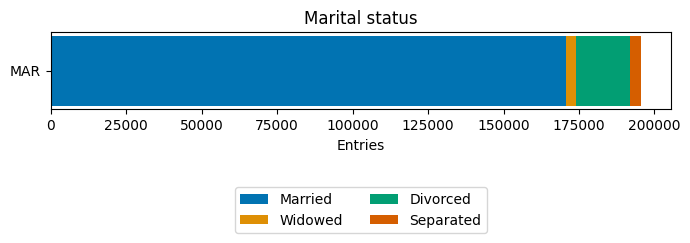

In [175]:
# Sample data for one stacked bar
labels = ["Married", "Widowed", "Divorced", "Separated", "Never married"]
values =  [sum(data[f"MAR_{i}"]) for i in range(2, 5)]
values = [len(data)-sum(values)]+values
Ncat=len(values)
colors =sns.color_palette('colorblind', Ncat)

# Create the horizontal stacked bar
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh(["MAR"], values[0], color=colors[0], label=labels[0])

for i in range(1,Ncat):
    ax.barh(["MAR"], values[i], left=sum(values[0:i]), color=colors[i], label=labels[i])
 
# Labels and legend
ax.set_xlabel("Entries")
ax.set_title("Marital status")
ax.legend(loc='lower center',bbox_to_anchor=(0.5, -1.7),ncol=2)

# Grouping the not married categories
data["MAR_2"]=data["MAR_2"]+data["MAR_3"]+data["MAR_4"]+data["MAR_5"]
data=data.drop(["MAR_3","MAR_4","MAR_5"],axis=1)

# Show plot
plt.show()

## Recoded detailed race code

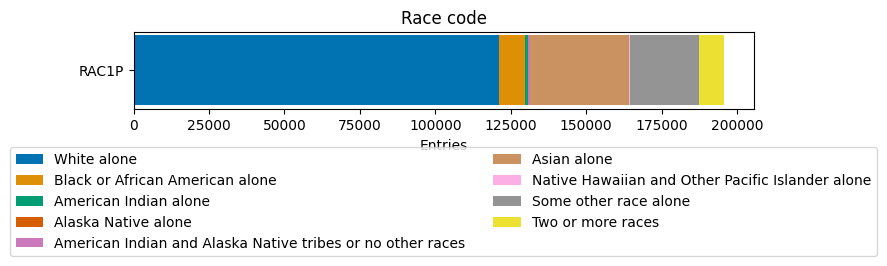

In [176]:
# Sample data for one stacked bar
labels = ["White alone","Black or African American alone","American Indian alone","Alaska Native alone","American Indian and Alaska Native tribes or no other races", "Asian alone","Native Hawaiian and Other Pacific Islander alone", "Some other race alone", "Two or more races"]
values = [sum(data[f"RAC1P_{i}"]) for i in range(2, 10)]
values = [len(data)-sum(values)]+values
# Number of categories
Ncat=len(values)

# Choosing color for stacked bar
colors =sns.color_palette('colorblind', Ncat)

# Create the horizontal stacked bar
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh(["RAC1P"], values[0], color=colors[0], label=labels[0])

for i in range(1,Ncat):
    ax.barh(["RAC1P"], values[i], left=sum(values[0:i]), color=colors[i], label=labels[i])
 
# Labels and legend
ax.set_xlabel("Entries")
ax.set_title("Race code")
ax.legend(loc='lower center',bbox_to_anchor=(0.5, -2),ncol=2)

# Show plot
plt.show()

## Insurance status

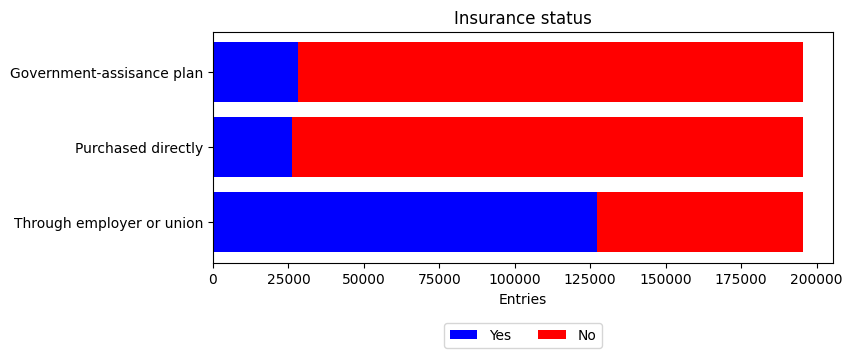

In [177]:
# Sample data for one stacked bar
labels = ["Yes", "No"]
HINS1values = [sum(data['HINS1_2'])]
HINS2values = [sum(data['HINS2_2'])]
HINS4values = [sum(data['HINS4_2'])]


HINS1values = [len(data)-sum(HINS1values)]+HINS1values
HINS2values = [len(data)-sum(HINS2values)]+HINS2values
HINS4values = [len(data)-sum(HINS4values)]+HINS4values

Ncat=2
colors =["blue","red"]

# Create the horizontal stacked bar
fig, ax = plt.subplots(figsize=(8, 3))
ax.barh(["Through employer or union"], HINS1values[0], color=colors[0], label=labels[0])
ax.barh(["Through employer or union"], HINS1values[1], left=HINS1values[0], color=colors[1], label=labels[1])

ax.barh(["Purchased directly"], HINS2values[0], color=colors[0])
ax.barh(["Purchased directly"], HINS2values[1], left=HINS2values[0], color=colors[1])

ax.barh(["Government-assisance plan"], HINS4values[0], color=colors[0])
ax.barh(["Government-assisance plan"], HINS4values[1], left=HINS4values[0], color=colors[1])


 
# Labels and legend
ax.set_xlabel("Entries")
ax.set_title("Insurance status")
ax.legend(loc='lower center',bbox_to_anchor=(0.5, -0.4),ncol=2)

# Show plot
plt.show()

## Constructing our train/test set


In [178]:
X_train, X_test, y_train, y_test, group_sex_train, group_sex_test, group_dis_train, group_dis_test, group_vps_train, group_vps_test = train_test_split(
    data, target, group_sex, group_dis, group_vps, test_size=0.2, random_state=0)
X_train["SEX_2"]=X_train["SEX_2"].astype(bool)
X_train["DIS_2"]=X_train["DIS_2"].astype(bool)
X_train["VPS_1"]=X_train["VPS_1"].astype(bool)
X_test["SEX_2"]=X_test["SEX_2"].astype(bool)
X_test["DIS_2"]=X_test["DIS_2"].astype(bool)
X_test["VPS_1"]=X_test["VPS_1"].astype(bool)

## Fitting logistic regression model

We set a reasonable threshold for our maximum iteration and tolerance. Moreover we want to make use of the penalty=”l2” loss function, to ensure no feature wheigts can be sat to zero. Therefore,we also need to give a reasonable scalar for the heights, which here is defined by C. This we obtained
from Lecture 2 notes. We wish to use the solver=”saga” since we have many categorical, one-hot-encoded variables thus resulting in a sparse dataset.

In [179]:
# Fitting a simple logistic regression model
WBmodel=LogisticRegression(max_iter=5000, penalty = "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga", class_weight='balanced')
WBmodel.fit(X_train,y_train)

# Reporting the accuracy
WBmodel.score(X_test, y_test)

0.7609434492627706

### Feature wheights
OBS wheigts need to be exp-translated because we have a logistic model. Be aware that it is harder to interpret the odds ratios for the scale features; AGE, SCHL and ENG. 

<Axes: ylabel='Feature'>

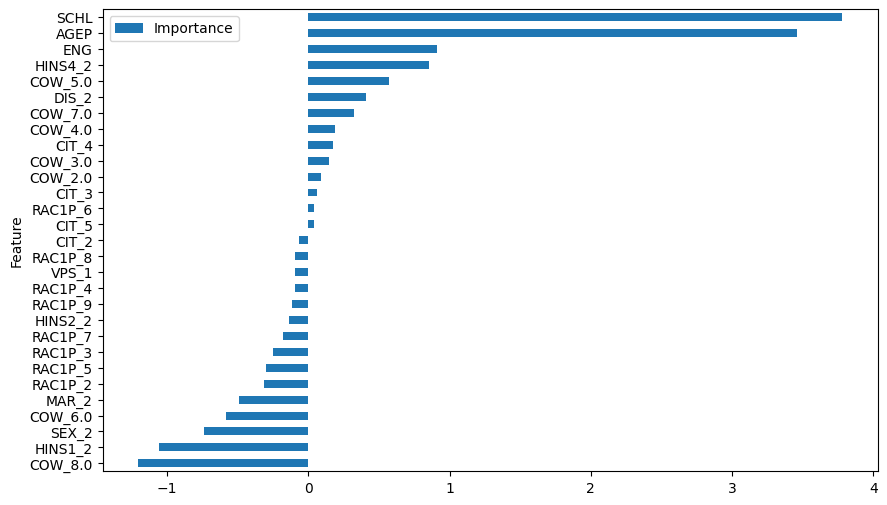

In [180]:
coefficients = WBmodel.coef_[0]

feature_importance = pd.DataFrame({'Feature': data.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

We see SEX_2 odds ratio = 0.48, meaning being SEX_2 (female) reduces your odds of being predicted high income by 52% <br>

We see DIS_2 odds ratio = 1.51, meaning being DIS_2 (without disability) increases your odds of being predicted high income by 51% <br>

We also see different odds ratios for the races, only a slight increase in odds for race code 6 (asian only) otherwise all other races gives lower odds, especially RAC1P_2 (black or african american)

In [181]:
odds_ratios = pd.DataFrame({'Feature': data.columns,'Importance': coefficients, 'Odds ratio': np.exp(coefficients)})
print(odds_ratios.sort_values('Importance',ascending=False))

    Feature  Importance  Odds ratio
2      SCHL    3.780423   43.834562
0      AGEP    3.462380   31.892777
1       ENG    0.910385    2.485279
5   HINS4_2    0.851412    2.342952
13  COW_5.0    0.573553    1.774562
27    DIS_2    0.412214    1.510158
15  COW_7.0    0.321617    1.379357
12  COW_4.0    0.191468    1.211026
8     CIT_4    0.176371    1.192880
11  COW_3.0    0.145362    1.156458
10  COW_2.0    0.089133    1.093227
7     CIT_3    0.063410    1.065464
23  RAC1P_6    0.041980    1.042873
9     CIT_5    0.037814    1.038538
6     CIT_2   -0.067430    0.934793
25  RAC1P_8   -0.090529    0.913448
28    VPS_1   -0.090901    0.913108
21  RAC1P_4   -0.095543    0.908879
26  RAC1P_9   -0.116407    0.890113
4   HINS2_2   -0.137940    0.871151
24  RAC1P_7   -0.176139    0.838502
20  RAC1P_3   -0.247081    0.781077
22  RAC1P_5   -0.302229    0.739169
19  RAC1P_2   -0.316076    0.729004
17    MAR_2   -0.492679    0.610987
14  COW_6.0   -0.582979    0.558233
18    SEX_2   -0.738973    0

## Fitting a random forest model


Explanation for the feature engineering and scaling steps

In [ ]:
# Model obtained from lecture 3
BBmodel = RandomForestClassifier(max_depth=5, 
                             random_state=23, 
                             n_jobs=-1, 
                             n_estimators=20) 

BBmodel.fit(X_train, y_train)
BBmodel.score(X_test, y_test) # Accuracy

0.7659009020519766

In [183]:
# Train your model
BBmodel = RandomForestClassifier(max_depth=5, 
                             random_state=47, 
                             n_jobs=-1, 
                             n_estimators=20)
BBmodel.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=20, n_jobs=-1, random_state=47)

## Accuracy for the models

In [184]:
# Predicted values
y_predWB=WBmodel.predict(X_test)
y_predBB=BBmodel.predict(X_test)

print('Accuracy White Box model =', accuracy_score(y_test, y_predWB))
print('Accuracy Black Box model =', accuracy_score(y_test, y_predBB))


Accuracy White Box model = 0.7609434492627706
Accuracy Black Box model = 0.7675619042751641


## Fairness metrics

Statistical parity, the probability for being chosen should be the same, regardless of group

Equalised odds, the probability of being chosen should be the same, regardless of your group and target properties. Thus controlling that the true positive rates and false positive rates are respectively the same.

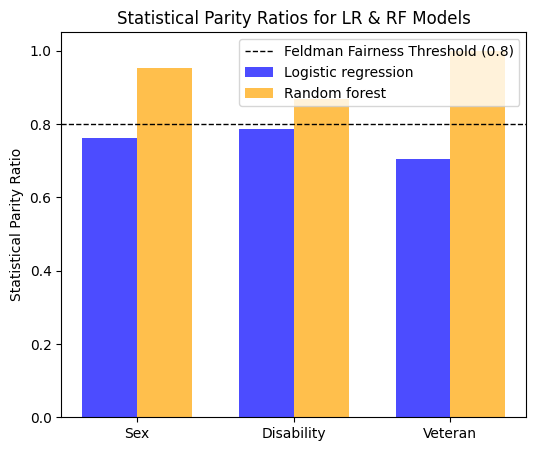

In [185]:
## Statistical parities for LR model
## Sex
SPSEX=np.zeros(2)
SPSEX[0]=np.mean(y_predWB[X_test["SEX_2"] == 0]) # Male
SPSEX[1]=np.mean(y_predWB[X_test["SEX_2"] == 1]) # Female
SPSEXratio=SPSEX[1]/SPSEX[0]

## Disability
SPDIS=np.zeros(2)
SPDIS[0]=np.mean(y_predWB[X_test["DIS_2"] == 0]) # Disabled
SPDIS[1]=np.mean(y_predWB[X_test["DIS_2"] == 1]) # Not disabled
SPDISratio=SPDIS[0]/SPDIS[1]

## Veteran
SPVPS=np.zeros(2)
SPVPS[0]=np.mean(y_predWB[X_test["VPS_1"] == 1]) # Veteran
SPVPS[1]=np.mean(y_predWB[X_test["VPS_1"] == 0]) # Not veteran
SPVPSratio=SPVPS[0]/SPVPS[1]

## Statistical parities for RF model

## Sex
SPSEXB=np.zeros(2)
SPSEXB[0]=np.mean(y_predBB[X_test["SEX_2"] == 0]) # Male
SPSEXB[1]=np.mean(y_predBB[X_test["SEX_2"] == 1]) # Female
SPSEXbratio=SPSEXB[1]/SPSEXB[0]

## Disability
SPDISB=np.zeros(2)
SPDISB[0]=np.mean(y_predBB[X_test["DIS_2"] == 0]) # Disabled
SPDISB[1]=np.mean(y_predBB[X_test["DIS_2"] == 1]) # Not disabled
SPDISbratio=SPDISB[0]/SPDISB[1]

## Veteran
SPVPSB=np.zeros(2)
SPVPSB[0]=np.mean(y_predBB[X_test["VPS_1"] == 0]) # Veteran
SPVPSB[1]=np.mean(y_predBB[X_test["VPS_1"] == 0]) # Not veteran
SPVPSbratio=SPVPSB[0]/SPVPSB[1]

# Statistical parity ratios
models = ["Logistic regression", "Random forest"]
categories = ["Sex", "Disability", "Veteran"]

# Ratio values from your calculations
ratios = np.array([
    [SPSEXratio, SPDISratio, SPVPSratio],   # Logistic Regression (LR)
    [SPSEXbratio, SPDISbratio, SPVPSbratio]  # Random Forest (RF)
])

# Bar plot setup
x = np.arange(len(categories))  # X-axis positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(6, 5))

# Plot bars
rects1 = ax.bar(x - width/2, ratios[0], width, label=models[0], color="blue", alpha=0.7)
rects2 = ax.bar(x + width/2, ratios[1], width, label=models[1], color="orange", alpha=0.7)

# Dashed fairness threshold line at 0.8
ax.axhline(y=0.8, color='black', linestyle='--', linewidth=1, label="Feldman Fairness Threshold (0.8)")

# Labels & formatting
ax.set_ylabel("Statistical Parity Ratio")
ax.set_title("Statistical Parity Ratios for LR & RF Models")
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Show plot
plt.show()


### Equilized odds

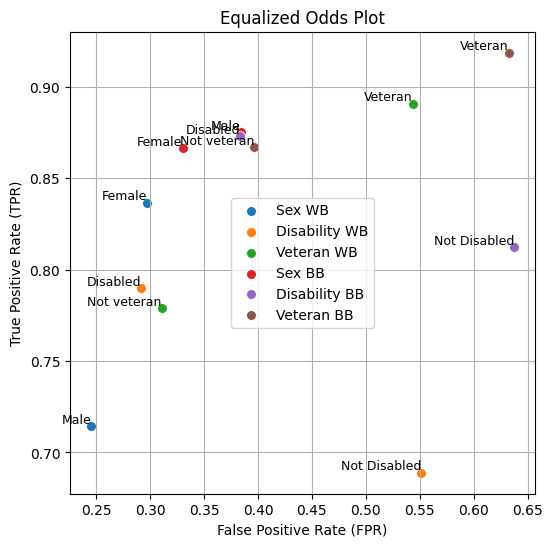

In [186]:
## Statistical parities for LR model
## Sex
TPRSEX=np.zeros(2)
TPRSEX[0]=np.mean(y_predWB[(X_test["SEX_2"]==1) & (y_test==1)])
TPRSEX[1]=np.mean(y_predWB[(X_test["SEX_2"]==0) & (y_test==1)])
FPRSEX=np.zeros(2)
FPRSEX[0]=np.mean(y_predWB[(X_test["SEX_2"]==1) & (y_test==0)])
FPRSEX[1]=np.mean(y_predWB[(X_test["SEX_2"]==0) & (y_test==0)])

## Disability
TPRDIS=np.zeros(2)
TPRDIS[0]=np.mean(y_predWB[(X_test["DIS_2"]==1) & (y_test==1)])
TPRDIS[1]=np.mean(y_predWB[(X_test["DIS_2"]==0) & (y_test==1)])
FPRDIS=np.zeros(2)
FPRDIS[0]=np.mean(y_predWB[(X_test["DIS_2"]==1) & y_test==0])
FPRDIS[1]=np.mean(y_predWB[(X_test["DIS_2"]==0) & y_test==0])

## Veteran
TPRVPS=np.zeros(2)
TPRVPS[0]=np.mean(y_predWB[(X_test["VPS_1"]==1) & y_test==1])
TPRVPS[1]=np.mean(y_predWB[(X_test["VPS_1"]==0) & y_test==1])
FPRVPS=np.zeros(2)
FPRVPS[0]=np.mean(y_predWB[(X_test["VPS_1"]==1) & y_test==0])
FPRVPS[1]=np.mean(y_predWB[(X_test["VPS_1"]==0) & y_test==0])

# Creating the plot
plt.figure(figsize=(6, 6))

# Plot data points for each group
sns.scatterplot(x=FPRSEX, y=TPRSEX, label="Sex WB", s=50)
sns.scatterplot(x=FPRDIS, y=TPRDIS, label="Disability WB", s=50)
sns.scatterplot(x=FPRVPS, y=TPRVPS, label="Veteran WB", s=50)


subgroups_sex = ["Male", "Female"]
subgroups_dis = ["Disabled", "Not Disabled"]
subgroups_vps = ["Not veteran", "Veteran"]

for i in range(len(TPRSEX)):
    plt.text(FPRSEX[i], TPRSEX[i], subgroups_sex[i], fontsize=9, ha="right", va="bottom")
    #plt.text(FPRSEX[i], TPRSEX[i], 'BB', fontsize=9, ha="right", va="top")
    plt.text(FPRDIS[i], TPRDIS[i], subgroups_dis[i], fontsize=9, ha="right", va="bottom")
    #plt.text(FPRDIS[i], TPRDIS[i], 'BB', fontsize=9, ha="right", va="top")
    plt.text(FPRVPS[i], TPRVPS[i], subgroups_vps[i], fontsize=9, ha="right", va="bottom")
    #plt.text(FPRVPS[i], TPRVPS[i], 'BB', fontsize=9, ha="right", va="top")


## Statistical parities for BB model
## Sex
TPRSEX=np.zeros(2)
TPRSEX[0]=np.mean(y_predBB[(X_test["SEX_2"]==1) & (y_test==1)])
TPRSEX[1]=np.mean(y_predBB[(X_test["SEX_2"]==0) & (y_test==1)])
FPRSEX=np.zeros(2)
FPRSEX[0]=np.mean(y_predBB[(X_test["SEX_2"]==1) & (y_test==0)])
FPRSEX[1]=np.mean(y_predBB[(X_test["SEX_2"]==0) & (y_test==0)])

## Disability
TPRDIS=np.zeros(2)
TPRDIS[0]=np.mean(y_predBB[(X_test["DIS_2"]==1) & (y_test==1)])
TPRDIS[1]=np.mean(y_predBB[(X_test["DIS_2"]==0) & (y_test==1)])
FPRDIS=np.zeros(2)
FPRDIS[0]=np.mean(y_predBB[(X_test["DIS_2"]==1) & y_test==0])
FPRDIS[1]=np.mean(y_predBB[(X_test["DIS_2"]==0) & y_test==0])

## Veteran
TPRVPS=np.zeros(2)
TPRVPS[0]=np.mean(y_predBB[(X_test["VPS_1"]==1) & y_test==1])
TPRVPS[1]=np.mean(y_predBB[(X_test["VPS_1"]==0) & y_test==1])
FPRVPS=np.zeros(2)
FPRVPS[0]=np.mean(y_predBB[(X_test["VPS_1"]==1) & y_test==0])
FPRVPS[1]=np.mean(y_predBB[(X_test["VPS_1"]==0) & y_test==0])


# Plot data points for each group
sns.scatterplot(x=FPRSEX, y=TPRSEX, label="Sex BB", s=50)
sns.scatterplot(x=FPRDIS, y=TPRDIS, label="Disability BB", s=50)
sns.scatterplot(x=FPRVPS, y=TPRVPS, label="Veteran BB", s=50)

for i in range(len(TPRSEX)):
    plt.text(FPRSEX[i], TPRSEX[i], subgroups_sex[i], fontsize=9, ha="right", va="bottom")
    #plt.text(FPRSEX[i], TPRSEX[i], 'wB', fontsize=9, ha="right", va="top")
    plt.text(FPRDIS[i], TPRDIS[i], subgroups_dis[i], fontsize=9, ha="right", va="bottom")
    #plt.text(FPRDIS[i], TPRDIS[i], 'wB', fontsize=9, ha="right", va="top")
    plt.text(FPRVPS[i], TPRVPS[i], subgroups_vps[i], fontsize=9, ha="right", va="bottom")
    #plt.text(FPRVPS[i], TPRVPS[i], 'wB', fontsize=9, ha="right", va="top")

# Labels and title
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Equalized Odds Plot")
plt.legend()
plt.grid(True)
plt.show()



In [187]:
# Checking the values
print("TPR for Disability Groups:", TPRDIS)
print("FPR for Disability Groups:", FPRDIS)

TPR for Disability Groups: [0.87276688 0.81212121]
FPR for Disability Groups: [0.38348306 0.63731222]


## Post-processing to fulfill fairness metric

In [188]:
postprocessor = ThresholdOptimizer(
    estimator=WBmodel,
    constraints="demographic_parity",  # "equalized_odds" 
    prefit=True  # Model is already trained
)
postprocessor.fit(X_train, y_train, sensitive_features=group_sex_train)
y_predWB_fairsex = postprocessor.predict(X_test, sensitive_features=group_sex_test)

postprocessor.fit(X_train, y_train, sensitive_features=group_dis_train)
y_predWB_fairdis = postprocessor.predict(X_test, sensitive_features=group_dis_test)

postprocessor.fit(X_train, y_train, sensitive_features=group_vps_train)
y_predWB_fairvps = postprocessor.predict(X_test, sensitive_features=group_vps_test)

### Making it fair for all groups

sensitive_features_train = pd.DataFrame({
    "SEX": group_sex_train,
    "DIS": group_dis_train,
    "VPS": group_vps_train
})

sensitive_features_test = pd.DataFrame({
    "SEX": group_sex_test,
    "DIS": group_dis_test,
    "VPS": group_vps_test
})

postprocessor.fit(X_train, y_train, sensitive_features=sensitive_features_train)
y_predWB_fair = postprocessor.predict(X_test, sensitive_features=sensitive_features_test)


# Evaluate Accuracy Before and After
print('Accuracy White Box model =', accuracy_score(y_test, y_predWB))
print('Accuracy White Box model fair for sex =', accuracy_score(y_test, y_predWB_fairsex))
print('Accuracy White Box model fair for disability =', accuracy_score(y_test, y_predWB_fairdis))
print('Accuracy White Box model fair for veterans =', accuracy_score(y_test, y_predWB_fairvps))
print('Accuracy White Box model fair for all =', accuracy_score(y_test, y_predWB_fair))


Accuracy White Box model = 0.7609434492627706
Accuracy White Box model fair for sex = 0.7632177446145197
Accuracy White Box model fair for disability = 0.7611989880663379
Accuracy White Box model fair for veterans = 0.760509033296706
Accuracy White Box model fair for all = 0.7608156798609869


In [189]:

y_predBB_P = BBmodel.predict_proba(X_test)[:, 1]
postprocessor = ThresholdOptimizer(
    estimator=BBmodel,
    constraints="demographic_parity",  # Change to "equalized_odds" 
    prefit=True  # Model is already trained
)
postprocessor.fit(X_train, y_train, sensitive_features=group_sex_train)
y_predBB_fairsex = postprocessor.predict(X_test, sensitive_features=group_sex_test)

postprocessor.fit(X_train, y_train, sensitive_features=group_dis_train)
y_predBB_fairdis = postprocessor.predict(X_test, sensitive_features=group_dis_test)

postprocessor.fit(X_train, y_train, sensitive_features=group_vps_train)
y_predBB_fairvps = postprocessor.predict(X_test, sensitive_features=group_vps_test)

### Making it fair for all groups

postprocessor.fit(X_train, y_train, sensitive_features=sensitive_features_train)
y_predBB_fair = postprocessor.predict(X_test, sensitive_features=sensitive_features_test)


# Evaluate Accuracy Before and After
print('Accuracy Black Box model =', accuracy_score(y_test, y_predBB))
print('Accuracy Black Box model fair for sex =', accuracy_score(y_test, y_predBB_fairsex))
print('Accuracy Black Box model fair for disability =', accuracy_score(y_test, y_predBB_fairdis))
print('Accuracy Black Box model fair for veterans =', accuracy_score(y_test, y_predBB_fairvps))
print('Accuracy Black Box model fair for all =', accuracy_score(y_test, y_predBB_fair))

Accuracy Black Box model = 0.7675619042751641
Accuracy Black Box model fair for sex = 0.7644443308716429
Accuracy Black Box model fair for disability = 0.769299568139422
Accuracy Black Box model fair for veterans = 0.7676641197965911
Accuracy Black Box model fair for all = 0.7634221756573736


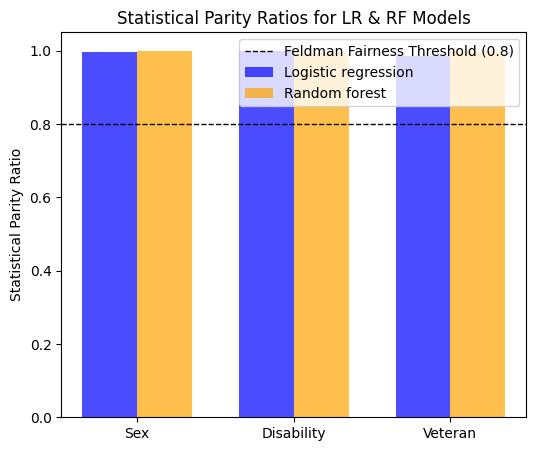

In [190]:
## Statistical parities for LR model
## Sex
SPSEX=np.zeros(2)
SPSEX[0]=np.mean(y_predWB_fair[X_test["SEX_2"] == 0]) # Male
SPSEX[1]=np.mean(y_predWB_fair[X_test["SEX_2"] == 1]) # Female
SPSEXratio=SPSEX[1]/SPSEX[0]

## Disability
SPDIS=np.zeros(2)
SPDIS[0]=np.mean(y_predWB_fair[X_test["DIS_2"] == 0]) # Disabled
SPDIS[1]=np.mean(y_predWB_fair[X_test["DIS_2"] == 1]) # Not disabled
SPDISratio=SPDIS[0]/SPDIS[1]

## Veteran
SPVPS=np.zeros(2)
SPVPS[0]=np.mean(y_predWB_fair[X_test["VPS_1"] == 1]) # Veteran
SPVPS[1]=np.mean(y_predWB_fair[X_test["VPS_1"] == 0]) # Not veteran
SPVPSratio=SPVPS[0]/SPVPS[1]

## Statistical parities for RF model

## Sex
SPSEXB=np.zeros(2)
SPSEXB[0]=np.mean(y_predBB_fair[X_test["SEX_2"] == 0]) # Male
SPSEXB[1]=np.mean(y_predBB_fair[X_test["SEX_2"] == 1]) # Female
SPSEXbratio=SPSEXB[1]/SPSEXB[0]

## Disability
SPDISB=np.zeros(2)
SPDISB[0]=np.mean(y_predBB_fair[X_test["DIS_2"] == 0]) # Disabled
SPDISB[1]=np.mean(y_predBB_fair[X_test["DIS_2"] == 1]) # Not disabled
SPDISbratio=SPDISB[0]/SPDISB[1]

## Veteran
SPVPSB=np.zeros(2)
SPVPSB[0]=np.mean(y_predBB_fair[X_test["VPS_1"] == 0]) # Veteran
SPVPSB[1]=np.mean(y_predBB_fair[X_test["VPS_1"] == 0]) # Not veteran
SPVPSbratio=SPVPSB[0]/SPVPSB[1]

# Statistical parity ratios
models = ["Logistic regression", "Random forest"]
categories = ["Sex", "Disability", "Veteran"]

# Ratio values from your calculations
ratios = np.array([
    [SPSEXratio, SPDISratio, SPVPSratio],   # Logistic Regression (LR)
    [SPSEXbratio, SPDISbratio, SPVPSbratio]  # Random Forest (RF)
])

# Bar plot setup
x = np.arange(len(categories))  # X-axis positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(6, 5))

# Plot bars
rects1 = ax.bar(x - width/2, ratios[0], width, label=models[0], color="blue", alpha=0.7)
rects2 = ax.bar(x + width/2, ratios[1], width, label=models[1], color="orange", alpha=0.7)

# Dashed fairness threshold line at 0.8
ax.axhline(y=0.8, color='black', linestyle='--', linewidth=1, label="Feldman Fairness Threshold (0.8)")

# Labels & formatting
ax.set_ylabel("Statistical Parity Ratio")
ax.set_title("Statistical Parity Ratios for LR & RF Models")
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Show plot
plt.show()

## Equalized odds after post-processing

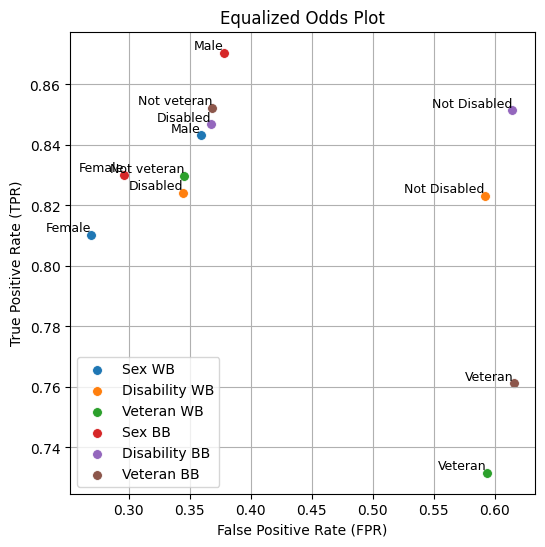

In [192]:
## Statistical parities for LR model
## Sex
TPRSEX=np.zeros(2)
TPRSEX[0]=np.mean(y_predWB_fair[(X_test["SEX_2"]==1) & (y_test==1)])
TPRSEX[1]=np.mean(y_predWB_fair[(X_test["SEX_2"]==0) & (y_test==1)])
FPRSEX=np.zeros(2)
FPRSEX[0]=np.mean(y_predWB_fair[(X_test["SEX_2"]==1) & (y_test==0)])
FPRSEX[1]=np.mean(y_predWB_fair[(X_test["SEX_2"]==0) & (y_test==0)])

## Disability
TPRDIS=np.zeros(2)
TPRDIS[0]=np.mean(y_predWB_fair[(X_test["DIS_2"]==1) & (y_test==1)])
TPRDIS[1]=np.mean(y_predWB_fair[(X_test["DIS_2"]==0) & (y_test==1)])
FPRDIS=np.zeros(2)
FPRDIS[0]=np.mean(y_predWB_fair[(X_test["DIS_2"]==1) & y_test==0])
FPRDIS[1]=np.mean(y_predWB_fair[(X_test["DIS_2"]==0) & y_test==0])

## Veteran
TPRVPS=np.zeros(2)
TPRVPS[0]=np.mean(y_predWB_fair[(X_test["VPS_1"]==1) & y_test==1])
TPRVPS[1]=np.mean(y_predWB_fair[(X_test["VPS_1"]==0) & y_test==1])
FPRVPS=np.zeros(2)
FPRVPS[0]=np.mean(y_predWB_fair[(X_test["VPS_1"]==1) & y_test==0])
FPRVPS[1]=np.mean(y_predWB_fair[(X_test["VPS_1"]==0) & y_test==0])

# Creating the plot
plt.figure(figsize=(6, 6))

# Plot data points for each group
sns.scatterplot(x=FPRSEX, y=TPRSEX, label="Sex WB", s=50)
sns.scatterplot(x=FPRDIS, y=TPRDIS, label="Disability WB", s=50)
sns.scatterplot(x=FPRVPS, y=TPRVPS, label="Veteran WB", s=50)


subgroups_sex = ["Male", "Female"]
subgroups_dis = ["Disabled", "Not Disabled"]
subgroups_vps = ["Not veteran", "Veteran"]

for i in range(len(TPRSEX)):
    plt.text(FPRSEX[i], TPRSEX[i], subgroups_sex[i], fontsize=9, ha="right", va="bottom")
    #plt.text(FPRSEX[i], TPRSEX[i], 'BB', fontsize=9, ha="right", va="top")
    plt.text(FPRDIS[i], TPRDIS[i], subgroups_dis[i], fontsize=9, ha="right", va="bottom")
    #plt.text(FPRDIS[i], TPRDIS[i], 'BB', fontsize=9, ha="right", va="top")
    plt.text(FPRVPS[i], TPRVPS[i], subgroups_vps[i], fontsize=9, ha="right", va="bottom")
    #plt.text(FPRVPS[i], TPRVPS[i], 'BB', fontsize=9, ha="right", va="top")


## Statistical parities for BB model
## Sex
TPRSEX=np.zeros(2)
TPRSEX[0]=np.mean(y_predBB_fair[(X_test["SEX_2"]==1) & (y_test==1)])
TPRSEX[1]=np.mean(y_predBB_fair[(X_test["SEX_2"]==0) & (y_test==1)])
FPRSEX=np.zeros(2)
FPRSEX[0]=np.mean(y_predBB_fair[(X_test["SEX_2"]==1) & (y_test==0)])
FPRSEX[1]=np.mean(y_predBB_fair[(X_test["SEX_2"]==0) & (y_test==0)])

## Disability
TPRDIS=np.zeros(2)
TPRDIS[0]=np.mean(y_predBB_fair[(X_test["DIS_2"]==1) & (y_test==1)])
TPRDIS[1]=np.mean(y_predBB_fair[(X_test["DIS_2"]==0) & (y_test==1)])
FPRDIS=np.zeros(2)
FPRDIS[0]=np.mean(y_predBB_fair[(X_test["DIS_2"]==1) & y_test==0])
FPRDIS[1]=np.mean(y_predBB_fair[(X_test["DIS_2"]==0) & y_test==0])

## Veteran
TPRVPS=np.zeros(2)
TPRVPS[0]=np.mean(y_predBB_fair[(X_test["VPS_1"]==1) & y_test==1])
TPRVPS[1]=np.mean(y_predBB_fair[(X_test["VPS_1"]==0) & y_test==1])
FPRVPS=np.zeros(2)
FPRVPS[0]=np.mean(y_predBB_fair[(X_test["VPS_1"]==1) & y_test==0])
FPRVPS[1]=np.mean(y_predBB_fair[(X_test["VPS_1"]==0) & y_test==0])

# Plot data points for each group
sns.scatterplot(x=FPRSEX, y=TPRSEX, label="Sex BB", s=50)
sns.scatterplot(x=FPRDIS, y=TPRDIS, label="Disability BB", s=50)
sns.scatterplot(x=FPRVPS, y=TPRVPS, label="Veteran BB", s=50)

for i in range(len(TPRSEX)):
    plt.text(FPRSEX[i], TPRSEX[i], subgroups_sex[i], fontsize=9, ha="right", va="bottom")
    #plt.text(FPRSEX[i], TPRSEX[i], 'wB', fontsize=9, ha="right", va="top")
    plt.text(FPRDIS[i], TPRDIS[i], subgroups_dis[i], fontsize=9, ha="right", va="bottom")
    #plt.text(FPRDIS[i], TPRDIS[i], 'wB', fontsize=9, ha="right", va="top")
    plt.text(FPRVPS[i], TPRVPS[i], subgroups_vps[i], fontsize=9, ha="right", va="bottom")
    #plt.text(FPRVPS[i], TPRVPS[i], 'wB', fontsize=9, ha="right", va="top")

# Labels and title
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Equalized Odds Plot")
plt.legend()
plt.grid(True)
plt.show()



## SHAP

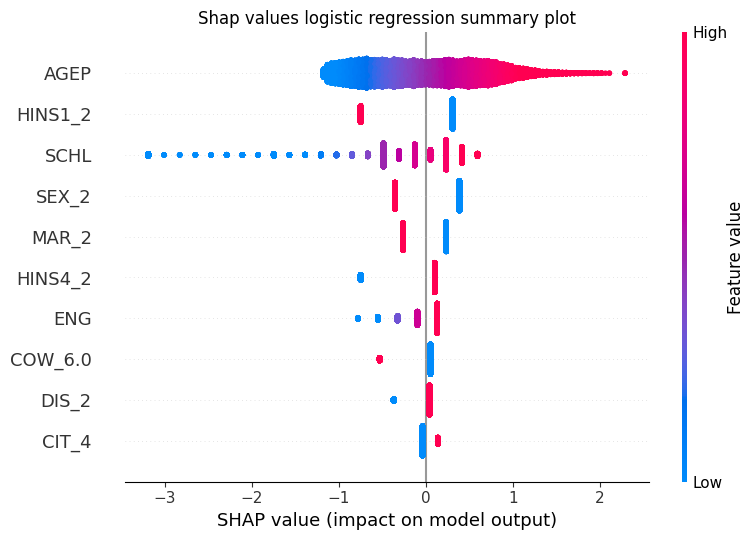

100%|===================| 78166/78266 [00:46<00:00]        

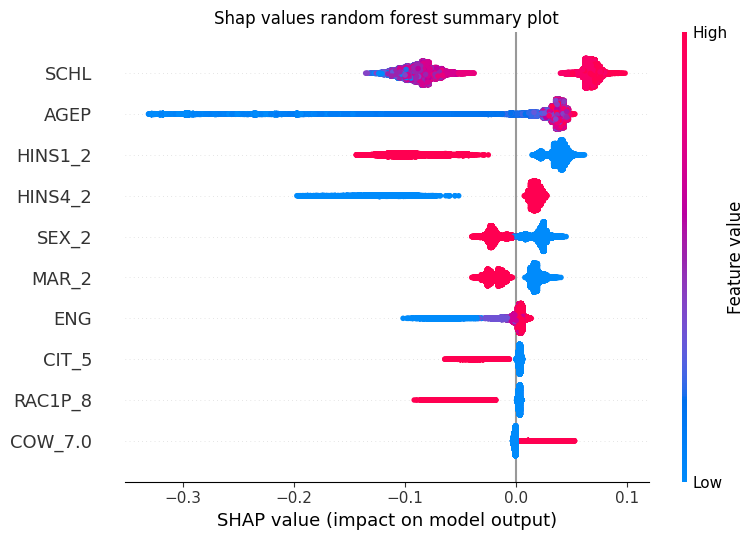

In [193]:
X_train=X_train.astype(float)
X_test=X_test.astype(float)

# White box

explainerWB = shap.Explainer(WBmodel, X_train, model_output='probability')
shap_valuesWB = explainerWB.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_valuesWB[:], X_test, 
                  feature_names=X_train.columns, 
                  max_display=10, show=False)

plt.title(f'Shap values logistic regression summary plot')
plt.tight_layout()

plt.show()

## Black box

explainer = shap.TreeExplainer(BBmodel, X_train, model_output='probability')
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values[:,:,1], X_test, 
                  feature_names=X_train.columns, 
                  max_display=10, show=False)

plt.title(f'Shap values random forest summary plot')
plt.tight_layout()
plt.show()